# Gaussian Processes Inferencing in Stingray


## Gaussian Processes in Astronomy

Explain Bayesian Analysis, Gaussian Processes, Evidence, use of GPs in Astronomy 


## Sample Lightcurve

Make a sample lightcurve, and fit a Red Noise Kernel gp using a just the dictionary for prior

In [1]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import seaborn as sns
sns.set_style('whitegrid')

from tinygp import GaussianProcess, kernels
from stingray import Lightcurve

jax.config.update("jax_enable_x64", True)

# May shift the ahead
import tensorflow_probability.substrates.jax as tfp
tfpd = tfp.distributions
tfpb = tfp.bijectors

/opt/homebrew/anaconda3/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


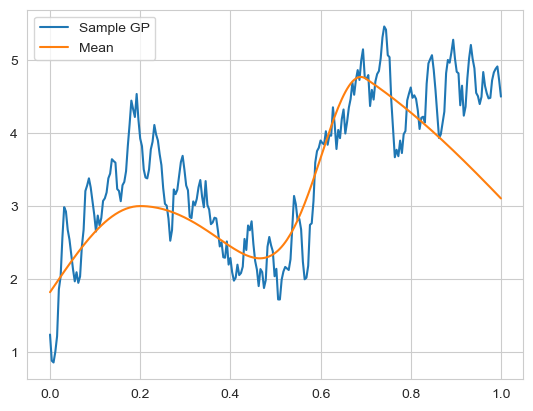

In [53]:
from gpmodelling import get_kernel, get_mean
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

Times = np.linspace(0,1,256)

kernel_params  = {"arn" : jnp.exp(-0.4),    "crn" : jnp.exp(1.5),
                  "aqpo": jnp.exp(-2),    "cqpo": jnp.exp(1.2),    "freq": 20,}
kernel = get_kernel(kernel_type = "QPO_plus_RN", kernel_params = kernel_params)

mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), 
               "sig1" : jnp.array([0.2, 0.1]), "sig2" : jnp.array([0.3, 0.4]),  }
mean = get_mean(mean_type = "skew_gaussian",  mean_params = mean_params)

gp = GaussianProcess(kernel = kernel, X = Times, mean_value = mean(Times), diag = 5e-3)
# gp = GaussianProcess(kernel = kernel, X = Times, mean = mean, diag = 5e-2)

# Plotting the GP
fig, ax = plt.subplots()
ax.plot(Times, gp.sample(key = jax.random.PRNGKey(3), shape= (1,)).T, label = "Sample GP")
ax.plot(Times, mean(Times), label = "Mean"); ax.legend()

plt.show()

INFO[2023-07-10 20:49:13,255]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-07-10 20:49:13,255]: Checking if light curve is sorted.


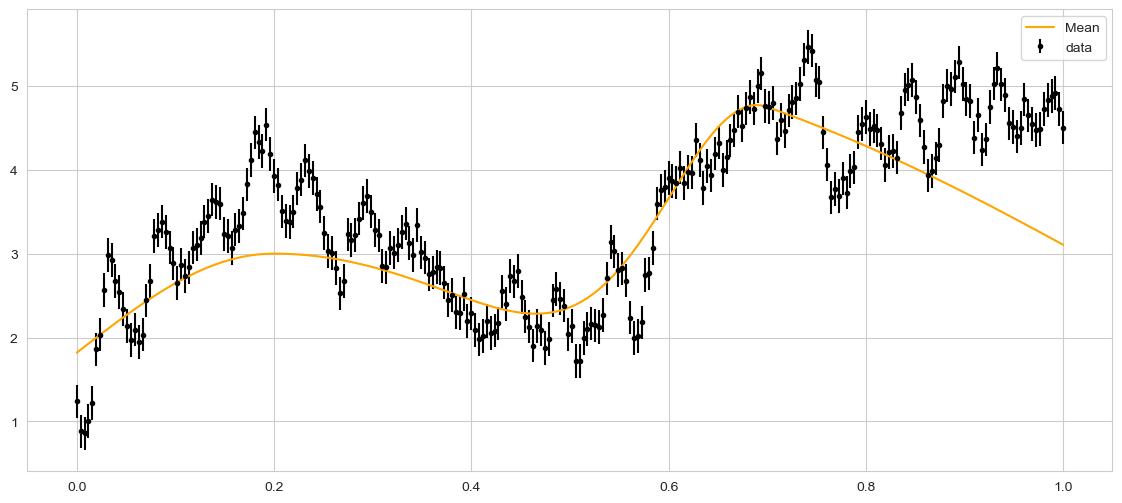

In [54]:
counts = sample = gp.sample(key = jax.random.PRNGKey(3))
yerr = (0.2)*np.ones_like(Times)
fig, ax = plt.subplots(1,1, figsize = (14,6))
plt.errorbar(Times, sample.T, yerr=yerr, fmt=".k", capsize=0, label="data")
ax.plot(Times, mean(Times), color = "orange" ,label = "Mean"); ax.legend()

lc = Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0])

In [55]:
from gpmodelling import get_prior, get_likelihood, get_gp_params

params_list = get_gp_params(kernel_type= "RN", mean_type = "gaussian")
print(params_list)

counts = sample
T = Times[-1] - Times[0]
f = 1/(Times[1]- Times[0])
span = jnp.max(counts) - jnp.min(counts)

# Can make multi mean A, sid, t0(the problem)
prior_dict = {
    "A": tfpd.Uniform(low = 0.1 * span, high = 2 * span),
    "t0": tfpd.Uniform(low = Times[0] - 0.1*T, high = Times[-1] + 0.1*T),
    "sig": tfpd.Uniform(low = 0.5 * 1 / f, high = 2 * T),
    "arn": tfpd.Uniform(low = 0.1 * span, high = 2 * span),
    "crn": tfpd.Uniform(low = jnp.log(1 / T), high = jnp.log(f)),
}
prior_model = get_prior(params_list, prior_dict)
for a in prior_model():
    print(a)

likelihood_model = get_likelihood(params_list, kernel_type= "RN", mean_type = "gaussian", Times = Times, counts = counts, yerr = yerr)

['arn', 'crn', 'A', 't0', 'sig']
arn	() -> () <class 'numpy.float64'>
crn	() -> () <class 'numpy.float64'>
A	() -> () <class 'numpy.float64'>
t0	() -> () <class 'numpy.float64'>
sig	() -> () <class 'numpy.float64'>


In [56]:
from gpmodelling import GPResult

Gpresult = GPResult(Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0]))
Gpresult.sample(prior_model = prior_model, likelihood_model = likelihood_model)

INFO[2023-07-10 20:49:21,229]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-07-10 20:49:21,230]: Checking if light curve is sorted.
INFO[2023-07-10 20:49:21,451]: Sanity check...
INFO[2023-07-10 20:49:21,453]: Sanity check passed


Simulation Complete


Evidence:  10.06268666621074


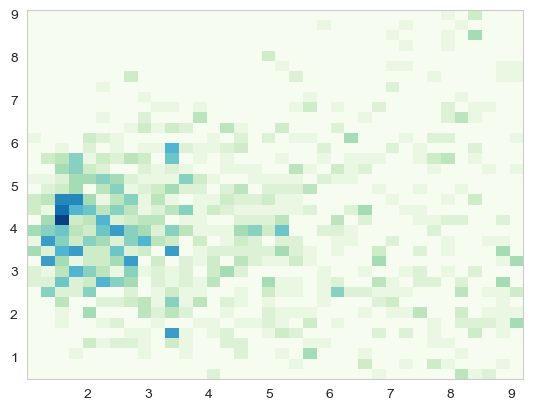

In [57]:
print("Evidence: ", Gpresult.get_evidence())
Gpresult.corner_plot("A", "arn", n1 = 0, n2 = 0)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 141154
# samples: 5152
# slices: 38500.0
# slices / acceptance: 11.0
# likelihood evals / sample: 27.4
# likelihood evals / slice: 3.5
--------
logZ=10.063 +- 0.08
H=960000.0
ESS=1236
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 3.9 +- 1.5 | 2.0 / 3.8 / 5.9 | 4.4 | 4.4
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 3.9 +- 2.2 | 1.6 / 3.4 / 7.5 | 1.2 | 1.2
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 2.4 +- 1.3 | 0.9 / 2.0 / 4.3 | 5.5 | 5.5
--------
sig: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sig: 1.07 +- 0.49 | 0.47 / 1.0 / 1.78 | 0.81 | 0.81
--------
t0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
t0: 0.69 +- 0.31 | 0.19 / 0.76 / 1.04 | 1.09 | 1.09
--------


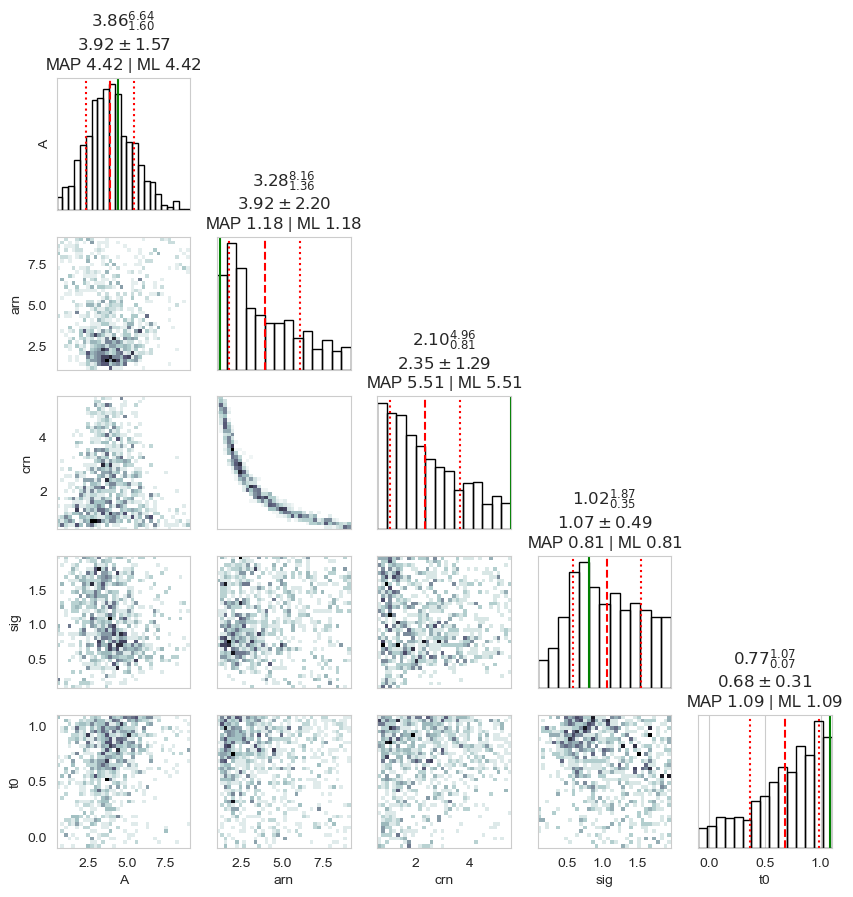

In [58]:
Gpresult.print_summary()
Gpresult.plot_cornerplot()

## Making own priors and log_likelihood functions

In [59]:
# QPO prior
from jaxns import Prior
from jaxns.special_priors import ForcedIdentifiability
from jaxns.types import float_type

params_list3 = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")
print(params_list3)

counts = sample
T = Times[-1] - Times[0]
f = 1/(Times[1]- Times[0])
span = jnp.max(counts) - jnp.min(counts)

# Can make multi mean A, sid, t0 with n = 2

def prior_model3():
    arn = yield Prior(tfpd.Uniform(low = 0.1 * span, high = 2 * span), name='arn')
    crn = yield Prior(tfpd.Uniform(low = jnp.log(1 / T), high = jnp.log(f)), name='crn')
    aqpo = yield Prior(tfpd.Uniform(low = 0.1 * span, high = 2 * span), name='aqpo')
    cqpo = yield Prior(tfpd.Uniform(low = 1/10/T, high = jnp.log(f)), name='cqpo')
    freq = yield Prior(tfpd.Uniform(low = 2 , high = f/4 ), name='freq')

    n = 2
    A = yield Prior(tfpd.Uniform(low = 0.1 * span*jnp.ones(n), high = 2 * span*jnp.ones(n)), name='A')
    
    # t0 = []
    # scale_bij = tfp.bijectors.Scale(scale = Times[-1] - Times[0])
    # shift_bij = tfp.bijectors.Shift(shift= Times[0])
    # for i in range(n):
    #     underlying_beta = tfpd.Beta(
    #         concentration1=jnp.asarray(1., float_type),
    #         concentration0=jnp.asarray(n - i, float_type)
    #     )
    #     t = yield Prior(shift_bij(scale_bij(underlying_beta)), name=f"t{i}")
    #     # Updating the shift and scale here
    #     scale_bij = tfp.bijectors.Scale(scale= Times[-1] - t)
    #     shift_bij = tfp.bijectors.Shift(shift=t)
    #     t0.append(t)
    # t0 = jnp.stack(t0)
    t0 = yield ForcedIdentifiability(n = n, low = Times[0] - 0.1*T, high = Times[-1] + 0.1*T, name='t0')
    sig = yield Prior(tfpd.Uniform(low = 0.5 * 1 / f *jnp.ones(n), high = 2 * T *jnp.ones(n)), name='sig')

    return arn, crn, aqpo, cqpo, freq, A, t0, sig


likelihood_model3 = get_likelihood(params_list3, kernel_type= "QPO_plus_RN", mean_type = "gaussian", Times = Times, counts = counts)

['arn', 'crn', 'aqpo', 'cqpo', 'freq', 'A', 't0', 'sig']


In [60]:
Gpresult3 = GPResult(Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0]))
Gpresult3.sample(prior_model = prior_model3, likelihood_model = likelihood_model3)

INFO[2023-07-10 20:49:36,476]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-07-10 20:49:36,477]: Checking if light curve is sorted.
INFO[2023-07-10 20:49:36,889]: Sanity check...
INFO[2023-07-10 20:49:36,891]: Sanity check passed


Simulation Complete


Evidence:  -114.07556824139613


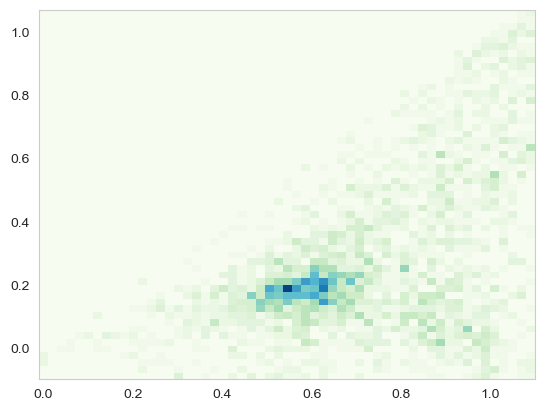

In [49]:
print("Evidence: ", Gpresult3.get_evidence())
Gpresult3.corner_plot("t0", "t0", n1 = 0, n2 = 1)

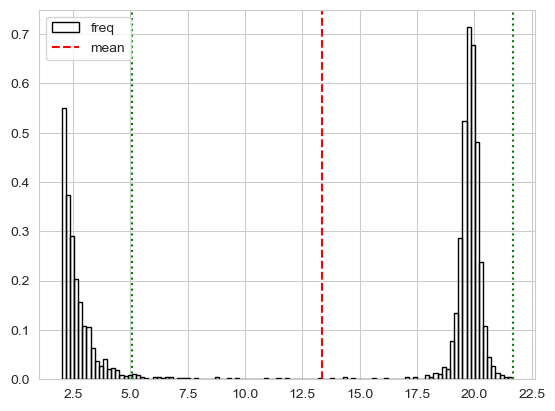

In [50]:
Gpresult3.weighted_posterior_plot("freq")

--------
Termination Conditions:
Reached max samples
Small remaining evidence
--------
# likelihood evals: 1361592
# samples: 10000
# slices: 559316.0
# slices / acceptance: 67.0
# likelihood evals / sample: 136.2
# likelihood evals / slice: 2.4
--------
logZ=-114.08 +- 0.14
H=110.0
ESS=3017
--------
A[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A[0]: 1.9 +- 1.3 | 0.7 / 1.6 / 3.5 | 0.7 | 0.7
A[1]: 3.5 +- 1.6 | 1.3 / 3.5 / 5.6 | 3.4 | 3.4
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: 1.05 +- 0.83 | 0.52 / 0.75 / 1.92 | 0.66 | 0.66
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 4.5 +- 1.6 | 2.9 / 3.9 / 6.8 | 3.0 | 3.0
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: 1.3 +- 1.6 | 0.1 / 0.3 / 4.3 | 0.1 | 0.1
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 3.6 +- 1.2 | 2.1 / 3.6 / 5.1 | 5.2 | 5.2
--

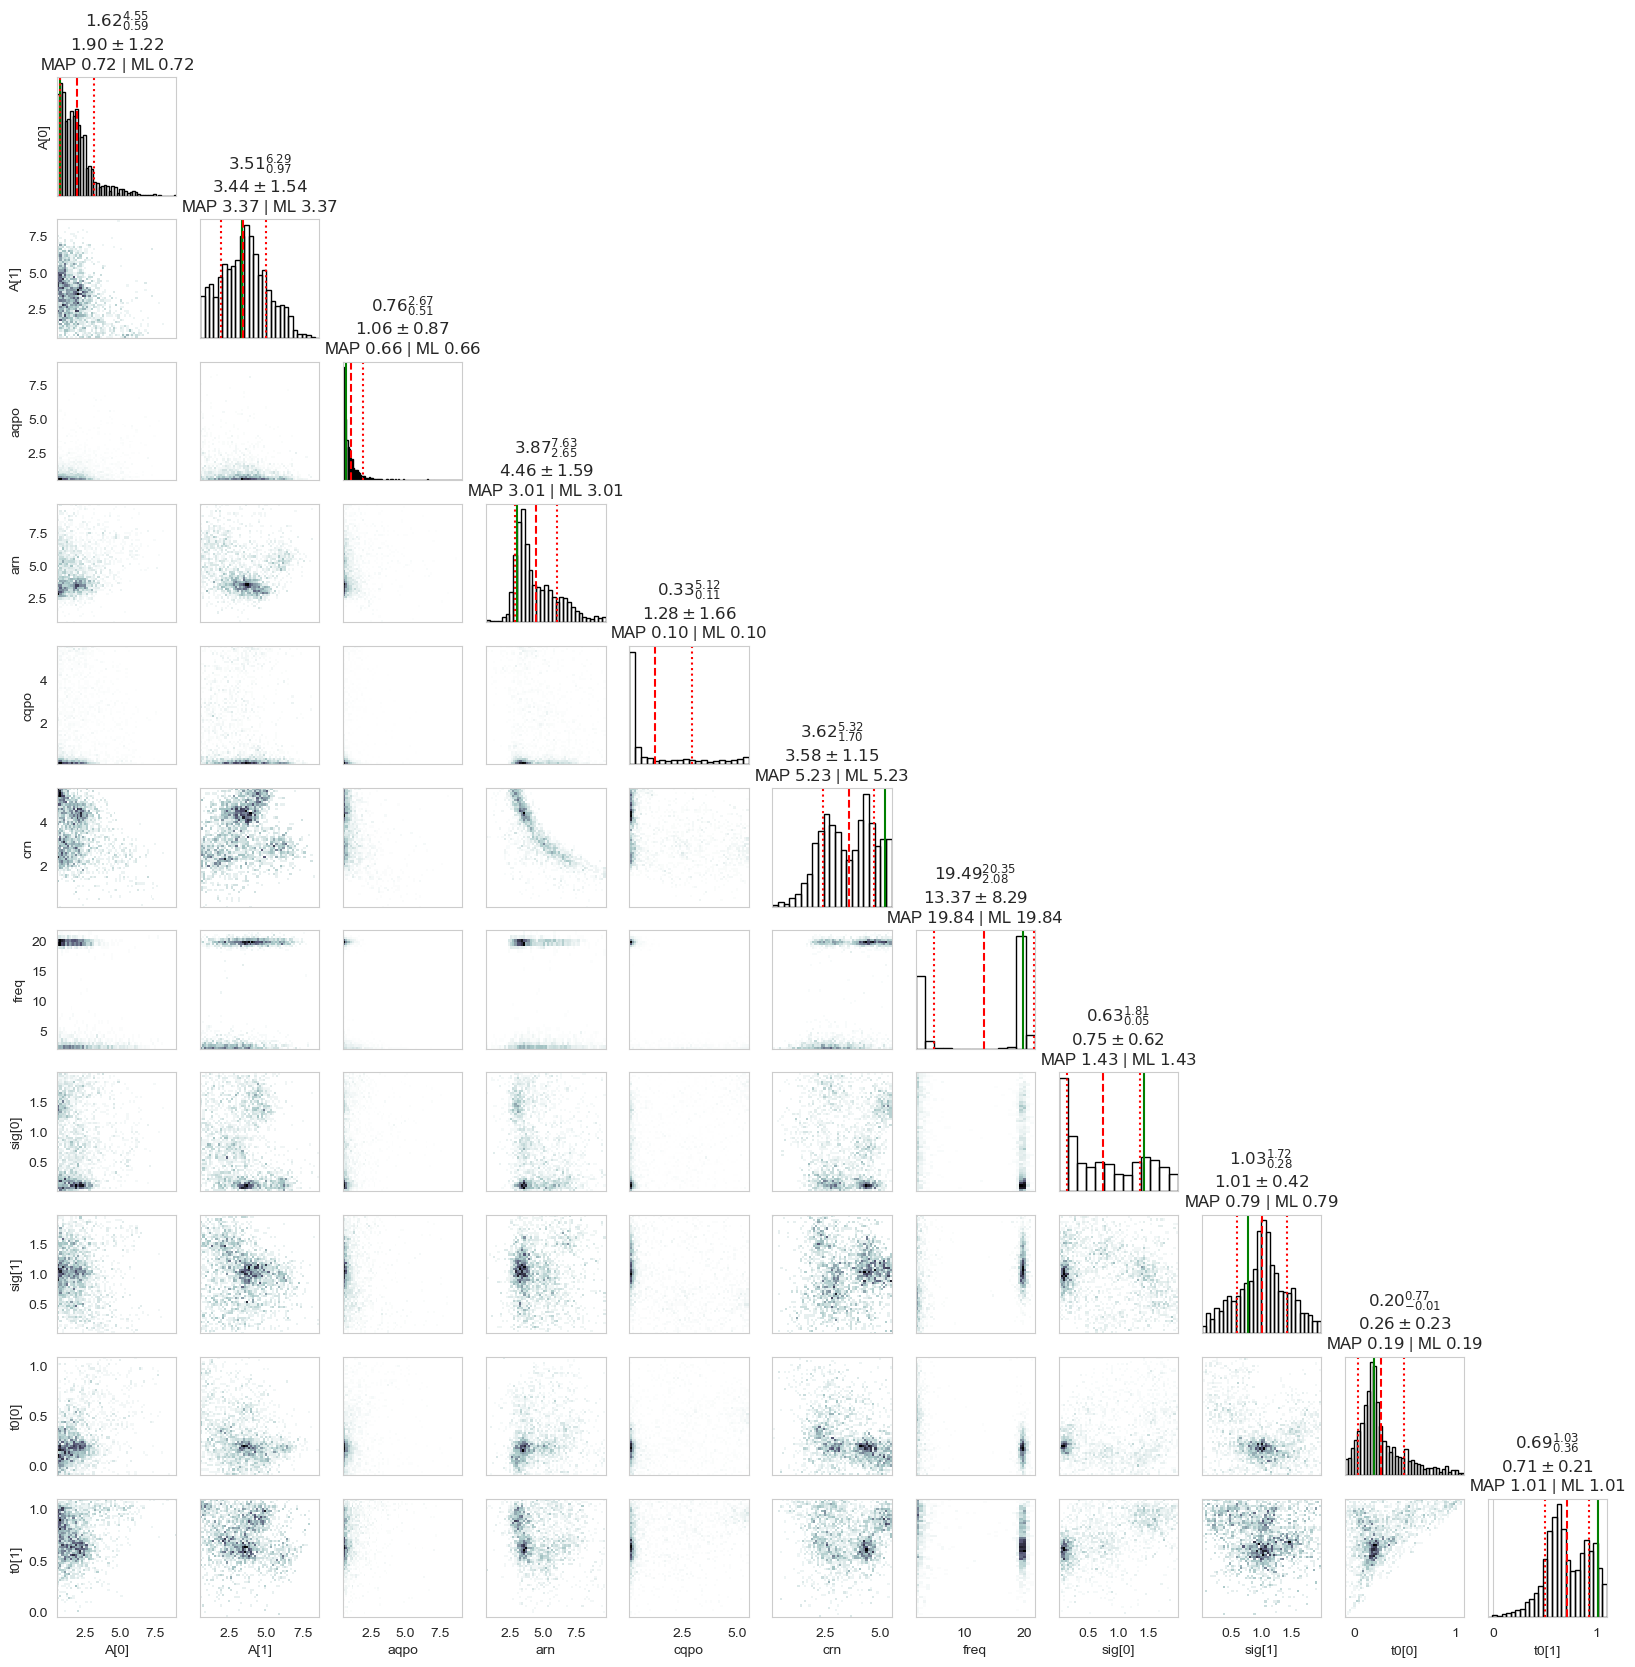

In [51]:
Gpresult3.print_summary()
Gpresult3.plot_cornerplot()